## Sentencepiece
> * sentencepiece 논문을 읽어봤을때, 가장 인상적인 부분은 raw data 즉, 날것의 데이터를 사용해도 괜찮다는 장점이 있었다는 내용이였습니다.<br/>그래서 날것의 데이터와 약간의 전처리를 한 데이터를 비교해보고 단어장의 크기와 sentencepiece 모델을 바꿔가며 실험해 보겠습니다.

#### 필요한 라이브러리 Import

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import csv

import sentencepiece as spm
from konlpy.tag import Mecab

import urllib.request
from sklearn.model_selection import train_test_split
import keras

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

#### 데이터 확인 및 전처리

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fdbed5a2c90>)

In [3]:
data = pd.read_table('ratings.txt')

In [4]:
data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


* 개수를 확인해 보겠습니다.

In [5]:
len(data)

200000

* null 값을 확인해 보겠습니다.

In [6]:
data.isnull().values.any()

True

* 제거하고 개수를 확인해 보겠습니다.

In [7]:
data = data.dropna(how = 'any')

In [8]:
data.isnull().values.any()

False

In [9]:
len(data)

199992

* 8개 밖에 없어 그대로 진행하겠습니다.

In [10]:
data.drop_duplicates(['document'],inplace = True)

* 중복값을 제거하고 개수를 확인해보겠습니다.

In [11]:
len(data)

194543

* 이제 라벨의 불균형이 있나 확인해보겠습니다.

<AxesSubplot:>

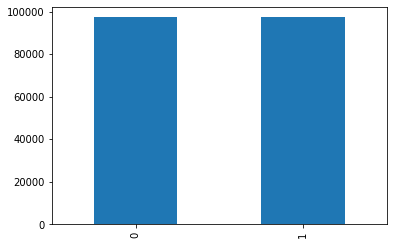

In [12]:
data['label'].value_counts().plot(kind = 'bar')

* 거의 비슷해 보입니다. 그대로 진행하겠습니다.

* train, val, test 데이터로 나누겠습니다.

In [13]:
train_data_raw, test_data_raw = train_test_split(data, test_size = 0.2, shuffle=True, random_state=5)

In [14]:
train_data_raw, val_data_raw = train_test_split(train_data_raw, test_size = 0.25, shuffle=True, random_state=5)

#### 데이터 분석

In [15]:
with open('ratings.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(data['document']))

In [16]:
with open('ratings.txt', "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 194543
Example:
>> 어릴때보고 지금다시봐도 재밌어요ㅋㅋ
>> 오랜만에 본 제대로 된 범죄스릴러~
>> 정의를 세우는 콜트, 콜텍 노동자들 이야기
>> 상당히 훌륭한 영화...
>> 내가 없어질 내인생. 제목을 참 잘 지었다.


* 데이터를 시각화 해보겠습니다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


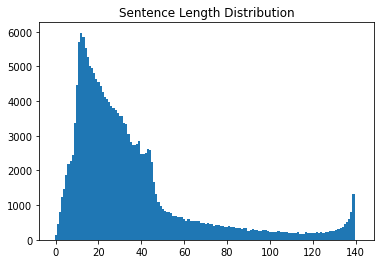

In [17]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

* 길이가 1개인 문장을 불러와보겠습니다.

In [19]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


* 의미 없어 보이는 단어가 많지만 날것의 데이터를 사욯해보겠습니다.

In [18]:
# 길이 조건에 맞는 문장만 선택합니다.
max_len = 142
min_len = 1

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

#### sentencepiece

In [20]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_uni_8000 --vocab_size={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_uni_8000*

-rw-r--r-- 1 root root 374793 Dec 20 00:33 korean_spm_uni_8000.model
-rw-r--r-- 1 root root 144213 Dec 20 00:33 korean_spm_uni_8000.vocab


* 처음엔 uni 모델에 단어장 8000으로 사용해 보겠습니다.

In [21]:
vocab_list = pd.read_csv('korean_spm_uni_8000.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print(len(vocab_list))
vocab_list[:10]

8000


,0,1
0,<pad>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,<unk>,0.00000
4,▁,-3.31583
5,.,-3.48007
6,..,-4.39015
7,이,-4.40538
8,▁영화,-4.58400
9,...,-4.63442


* 단어장이 잘 만들어진것 같습니다. 모델을 불러와 사용해보겠습니다.

In [22]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_uni_8000.model')

True

In [23]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('가슴이웅장해진다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('가슴이웅장해진다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1095, 2348, 138, 3861, 5]
['▁가슴이', '웅', '장', '해진다', '.']
가슴이웅장해진다.


* sentencepiece가 잘 동작합니다. 이를 활용해 토크나이저 함수를 정의하겠습니다.

In [24]:
def sp_tokenize(s, corpus, max_len):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = max_len)

    return tensor, word_index, index_word

In [71]:
#sp_tokenize(s, corpus, max_len) 사용예제

my_corpus = ['가슴이 웅장해진다.', '세계관 최강영화다..']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, max_len)
print(tensor)

[[  720 10918  3626     4     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 6333  4358  1479     6     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


* 토크나이저 함수로 토큰화하겠습니다.

In [27]:
# 토큰화
X_train_raw, word_index_train, index_word_train = sp_tokenize(s, train_data_raw['document'], max_len)
X_val_raw, word_index_val, index_word_val = sp_tokenize(s, val_data_raw['document'], max_len)
X_test_raw, word_index_test, index_word_test = sp_tokenize(s, test_data_raw['document'], max_len)

In [30]:
print('X_train_raw의 shape:', X_train_raw.shape)
print('X_val_raw의 shape:', X_val_raw.shape)
print('X_test_raw의 shape:', X_test_raw.shape)

X_train_raw의 shape: (116725, 142)
X_val_raw의 shape: (38909, 142)
X_test_raw의 shape: (38909, 142)


In [31]:
y_train_raw = np.array(list(train_data_raw['label']))
y_val_raw = np.array(list(val_data_raw['label']))
y_test_raw = np.array(list(test_data_raw['label']))

* LSTM 모델을 사용해 보겠습니다.

In [32]:
model = keras.Sequential()
model.add(keras.layers.Embedding(8000, 400, input_shape=(None,)))# input_shape을 None으로 명시해주는 것은 음이 아닌 정수가 들어올것
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 400)         3200000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               270848    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,471,889
Trainable params: 3,471,889
Non-trainable params: 0
_________________________________________________________________


In [33]:
file_path = os.getenv('HOME') +  '/aiffel/sp_tokenizer'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(file_path + '/model/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_raw,
                    y_train_raw,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_raw, y_val_raw),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
228/228 [==============================] - 43s 174ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4957

Epoch 00001: val_accuracy improved from -inf to 0.49572, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 2/20
228/228 [==============================] - 39s 172ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4957

Epoch 00002: val_accuracy did not improve from 0.49572
Epoch 3/20
228/228 [==============================] - 39s 173ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4957

Epoch 00003: val_accuracy did not improve from 0.49572
Epoch 4/20
228/228 [==============================] - 39s 172ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5043

Epoch 00004: val_accuracy improved from 0.49572 to 0.50428, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 5/20
228/228 [==============================] - 39s 173

* 정확도가 너무 심각하게 낮습니다.

In [35]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test_raw, y_test_raw, verbose=1)

1216/1216 [==============================] - 13s 11ms/step - loss: 0.6932 - accuracy: 0.4982


[0.6931562423706055, 0.4982137680053711]

* 혹시나 해서 테스트를 돌려보아도 정확도가 너무 낮습니다.<br/> CNN 모델을 사용해 보겠습니다.

In [36]:
model = keras.Sequential()
model.add(keras.layers.Embedding(8000, 400, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 400)         3200000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          44816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [37]:
file_path = os.getenv('HOME') +  '/aiffel/sp_tokenizer'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(file_path + '/model/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
# 학습의 진행
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_raw,
                    y_train_raw,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_raw, y_val_raw),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
228/228 [==============================] - 40s 155ms/step - loss: 0.6050 - accuracy: 0.6384 - val_loss: 0.3536 - val_accuracy: 0.8459

Epoch 00001: val_accuracy improved from -inf to 0.84590, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 2/20
228/228 [==============================] - 29s 129ms/step - loss: 0.3099 - accuracy: 0.8698 - val_loss: 0.3358 - val_accuracy: 0.8536

Epoch 00002: val_accuracy improved from 0.84590 to 0.85361, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 3/20
228/228 [==============================] - 29s 129ms/step - loss: 0.2505 - accuracy: 0.8997 - val_loss: 0.3440 - val_accuracy: 0.8544

Epoch 00003: val_accuracy improved from 0.85361 to 0.85435, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 4/20
228/228 [==============================] - 29s 129ms/step - loss: 0.1815 - accuracy: 0.9344 - val_loss: 0.3944 - val_accuracy: 0.8472

Epoch 00004: val_accuracy did not improve from 

* 정확도가 훨씬 높게 나왔습니다.

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### 학습과정 시각화

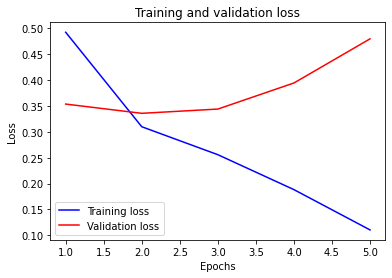

In [40]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

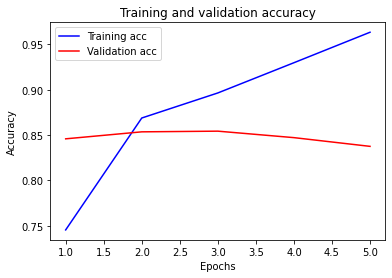

In [41]:
plt.clf()   

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test_raw, y_test_raw, verbose=1)

1216/1216 [==============================] - 8s 5ms/step - loss: 0.3419 - accuracy: 0.8531


[0.34194350242614746, 0.8530930876731873]

* 테스트에서도 높은 수치가 나왔네요. <br/> 이제 날것의 데이터가 아닌 어느정도 문장 길이를 잘라 사용해 보겠습니다.

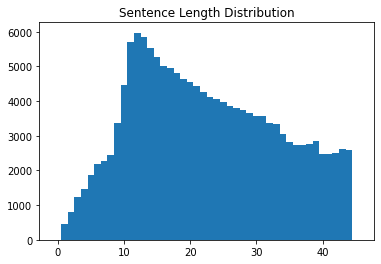

In [43]:
max_len = 46
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

* 어느정도 가우시안 분포가 나오게끔 임의로 설정했습니다.

In [44]:
train_data = train_data_raw[(train_data_raw['document'].map(len) <= max_len)*(train_data_raw['document'].map(len) >= min_len)]
val_data = val_data_raw[(val_data_raw['document'].map(len) <= max_len)*(val_data_raw['document'].map(len) >= min_len)]
test_data = test_data_raw[(test_data_raw['document'].map(len) <= max_len)*(test_data_raw['document'].map(len) >= min_len)]

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [45]:
# 토큰화
s = spm.SentencePieceProcessor()
s.Load('korean_spm_uni_8000.model')

X_train, word_index_train, index_word_train = sp_tokenize(s, train_data['document'], max_len)
X_val, word_index_val, index_word_val = sp_tokenize(s, val_data['document'], max_len)
X_test, word_index_test, index_word_test = sp_tokenize(s, test_data['document'], max_len)

In [46]:
print('X_train의 shape:', X_train.shape)
print('X_val의 shape:', X_val.shape)
print('X_test의 shape:', X_test.shape)

X_train의 shape: (92698, 46)
X_val의 shape: (30919, 46)
X_test의 shape: (30876, 46)


In [47]:
y_train = np.array(list(train_data['label']))
y_val = np.array(list(val_data['label']))
y_test = np.array(list(test_data['label']))

In [48]:
model = keras.Sequential()
model.add(keras.layers.Embedding(8000, 400, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 400)         3200000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          44816     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [49]:
file_path = os.getenv('HOME') +  '/aiffel/sp_tokenizer'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(file_path + '/model/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [50]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
182/182 [==============================] - 19s 85ms/step - loss: 0.6105 - accuracy: 0.6330 - val_loss: 0.3674 - val_accuracy: 0.8373

Epoch 00001: val_accuracy improved from -inf to 0.83725, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 2/20
182/182 [==============================] - 10s 53ms/step - loss: 0.3151 - accuracy: 0.8670 - val_loss: 0.3555 - val_accuracy: 0.8437

Epoch 00002: val_accuracy improved from 0.83725 to 0.84366, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 3/20
182/182 [==============================] - 10s 53ms/step - loss: 0.2645 - accuracy: 0.8932 - val_loss: 0.3650 - val_accuracy: 0.8435

Epoch 00003: val_accuracy did not improve from 0.84366
Epoch 4/20
182/182 [==============================] - 10s 53ms/step - loss: 0.1981 - accuracy: 0.9270 - val_loss: 0.4077 - val_accuracy: 0.8323

Epoch 00004: val_accuracy did not improve from 0.84366
Epoch 5/20
182/182 [==============================] - 10s 54ms/st

In [51]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test, y_test, verbose=1)

965/965 [==============================] - 6s 5ms/step - loss: 0.3504 - accuracy: 0.8456


[0.3504053056240082, 0.8455758690834045]

* 학습이 끝나 테스트를 돌려보았습니다. 차이가 별로 없습니다.

* 이제 센텐스피스의 단어장의 개수와 모델별로 학습시켜보겠습니다.

In [52]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_8000 --vocab_size={} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe_8000*

-rw-r--r-- 1 root root 370270 Dec 20 00:47 korean_spm_bpe_8000.model
-rw-r--r-- 1 root root 115471 Dec 20 00:47 korean_spm_bpe_8000.vocab


In [53]:
vocab_size = 24000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_uni_24000 --vocab_size={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_uni_24000*

-rw-r--r-- 1 root root 696687 Dec 20 00:48 korean_spm_uni_24000.model
-rw-r--r-- 1 root root 480263 Dec 20 00:48 korean_spm_uni_24000.vocab


In [54]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_24000 --vocab_size={} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe_24000*

-rw-r--r-- 1 root root 679503 Dec 20 00:49 korean_spm_bpe_24000.model
-rw-r--r-- 1 root root 406698 Dec 20 00:49 korean_spm_bpe_24000.vocab


* CNN 모델이 좋아 함수로 바꿔 사용하겠습니다.

In [55]:
def CNN_model(vocab_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 400, input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(4))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

* 토큰화

In [57]:
# 토큰화
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_8000.model')

X_train_raw, word_index_train, index_word_train = sp_tokenize(s, train_data_raw['document'], max_len)
X_val_raw, word_index_val, index_word_val = sp_tokenize(s, val_data_raw['document'], max_len)
X_test_raw, word_index_test, index_word_test = sp_tokenize(s, test_data_raw['document'], max_len)

In [63]:
# 토큰화
s = spm.SentencePieceProcessor()
s.Load('korean_spm_uni_24000.model')

X_train_raw_uni_24000, word_index_train, index_word_train = sp_tokenize(s, train_data_raw['document'], max_len)
X_val_raw_uni_24000, word_index_val, index_word_val = sp_tokenize(s, val_data_raw['document'], max_len)
X_test_raw_uni_24000, word_index_test, index_word_test = sp_tokenize(s, test_data_raw['document'], max_len)

In [60]:
# 토큰화
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_24000.model')

X_train_raw_bpe_24000, word_index_train, index_word_train = sp_tokenize(s, train_data_raw['document'], max_len)
X_val_raw_bpe_24000, word_index_val, index_word_val = sp_tokenize(s, val_data_raw['document'], max_len)
X_test_raw_bpe_24000, word_index_test, index_word_test = sp_tokenize(s, test_data_raw['document'], max_len)

* 모델학습

In [58]:
model = CNN_model(8000)

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_raw,
                    y_train_raw,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_raw, y_val_raw),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
228/228 [==============================] - 19s 81ms/step - loss: 0.5680 - accuracy: 0.6792 - val_loss: 0.3533 - val_accuracy: 0.8452

Epoch 00001: val_accuracy improved from 0.84366 to 0.84515, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 2/20
228/228 [==============================] - 13s 57ms/step - loss: 0.2984 - accuracy: 0.8746 - val_loss: 0.3435 - val_accuracy: 0.8519

Epoch 00002: val_accuracy improved from 0.84515 to 0.85186, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 3/20
228/228 [==============================] - 12s 54ms/step - loss: 0.2280 - accuracy: 0.9114 - val_loss: 0.3637 - val_accuracy: 0.8467

Epoch 00003: val_accuracy did not improve from 0.85186
Epoch 4/20
228/228 [==============================] - 12s 53ms/step - loss: 0.1358 - accuracy: 0.9549 - val_loss: 0.4445 - val_accuracy: 0.8383

Epoch 00004: val_accuracy did not improve from 0.85186
Epoch 5/20
228/228 [==============================] - 12s 53ms

In [65]:
model = CNN_model(24000)

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_raw_uni_24000,
                    y_train_raw,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_raw_uni_24000, y_val_raw),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
228/228 [==============================] - 29s 123ms/step - loss: 0.5922 - accuracy: 0.6566 - val_loss: 0.3433 - val_accuracy: 0.8475

Epoch 00001: val_accuracy did not improve from 0.85186
Epoch 2/20
228/228 [==============================] - 28s 123ms/step - loss: 0.2570 - accuracy: 0.8973 - val_loss: 0.3453 - val_accuracy: 0.8528

Epoch 00002: val_accuracy improved from 0.85186 to 0.85278, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 3/20
228/228 [==============================] - 28s 121ms/step - loss: 0.1479 - accuracy: 0.9488 - val_loss: 0.4158 - val_accuracy: 0.8463

Epoch 00003: val_accuracy did not improve from 0.85278
Epoch 4/20
228/228 [==============================] - 27s 120ms/step - loss: 0.0624 - accuracy: 0.9829 - val_loss: 0.5436 - val_accuracy: 0.8426

Epoch 00004: val_accuracy did not improve from 0.85278
Epoch 00004: early stopping


In [67]:
model = CNN_model(24000)

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train_raw_bpe_24000,
                    y_train_raw,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_raw_bpe_24000, y_val_raw),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
228/228 [==============================] - 29s 122ms/step - loss: 0.5886 - accuracy: 0.6601 - val_loss: 0.3564 - val_accuracy: 0.8429

Epoch 00001: val_accuracy did not improve from 0.85278
Epoch 2/20
228/228 [==============================] - 28s 123ms/step - loss: 0.2655 - accuracy: 0.8932 - val_loss: 0.3442 - val_accuracy: 0.8537

Epoch 00002: val_accuracy improved from 0.85278 to 0.85366, saving model to /aiffel/aiffel/sp_tokenizer/model/best_model.h5
Epoch 3/20
228/228 [==============================] - 27s 121ms/step - loss: 0.1620 - accuracy: 0.9429 - val_loss: 0.3967 - val_accuracy: 0.8454

Epoch 00003: val_accuracy did not improve from 0.85366
Epoch 4/20
228/228 [==============================] - 28s 122ms/step - loss: 0.0782 - accuracy: 0.9768 - val_loss: 0.5322 - val_accuracy: 0.8395

Epoch 00004: val_accuracy did not improve from 0.85366
Epoch 5/20
228/228 [==============================] - 27s 121ms/step - loss: 0.0356 - accuracy: 0.9907 - val_loss: 0.6533 - val

* 모델 테스트

In [61]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test_raw, y_test_raw, verbose=1)

1216/1216 [==============================] - 5s 4ms/step - loss: 0.3429 - accuracy: 0.8510


[0.34293657541275024, 0.8510370254516602]

In [66]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test_raw_uni_24000, y_test_raw, verbose=1)

1216/1216 [==============================] - 4s 3ms/step - loss: 0.3455 - accuracy: 0.8523


[0.3454553782939911, 0.8522964119911194]

In [68]:
model = keras.models.load_model(file_path + "/model/best_model.h5")
model.evaluate(X_test_raw_bpe_24000, y_test_raw, verbose=1)

1216/1216 [==============================] - 4s 3ms/step - loss: 0.3446 - accuracy: 0.8514


[0.3446081578731537, 0.8514225482940674]

* 결과표

|데이터|test_loss|test_acc|
|------|---|---|
|uni_8000|0.3504|0.8456|
|uni_8000_raw|**0.3419**|**0.8531**|
|uni_24000_raw|0.3429|0.8510|
|bpe_8000_raw|0.3455|0.8523|
|bpe_24000_raw|0.3446|0.8514|

## 회고
* 처음에 RNN모델을 사용해서 정확도가 0.5에 머물러 있었는데, 아무래도 전처리를 안하고 데이터를 바로 토큰화해서 Ex07보다 성능이 떨어 진것 같습니다.
* 센텐스피스의 모델명을 바꿔보고 단어장의 크기도 3배로 늘려보아서 비교해 보았는데 엄청나게 큰 차이는 없었습니다. <br/> 아무래도 데이터의 전처리를 하지 않고 사용했기 때문에 하이퍼 파라미터만으로 엄청나게 큰 차이를 만들어 내지 못한 듯 합니다.
* 논문에서 가공되지 않은 데이터를 사용할 수 있어 좋다고 했었는데 꽤 괜찮은 성능이 나왔습니다. Ex07에서는 가공을 열심히 하고 간신히 85%이상의 성능을 냈습니다. 그래서 전처리도 거의 하지 않고 85%이상의 정확도를 만들었기 때문에 가공을 하면 더 좋을거라 생각했지만 단순히 너무 길고 짧은 문장만 제거한다고 성능의 향상은 없었고 학습모델의 차이에 가장큰 변화가 있었습니다.